<a href="https://colab.research.google.com/github/kiyong21c/nadocoding/blob/master/20220410_nueralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인공신경망으로 모델 만들기
- 로지스틱회귀에서는 교차 검증을 사용해 모델을 평가하지만, 인공신경망에서는 검증세트를 별도로 덜어내 사용
- 이유
  1. 딥러닝 분야의 데이터셋은 충분히 크다
  2. 교차 검증을 수행하는 훈련시간이 오래(몇시간 ~ 수일) 걸린다.

### 패션 MNIST 데이터셋
- 머신러닝에는 붓꽃데이터셋이 유명
- 딥러닝에서는 MNIST데이터셋이 유명 : 손으로쓴 0~9 숫자데이터
- 패션 MNIST데이터셋 : MNIST와 크기/개수 동일하고 숫자대신 패션 아이템으로 이루어진 데이터

In [1]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data() # sample_data 폴더에 csv내려받아짐
# 데이터를 load하면서 바로 훈련세트와 테스트세트가 분리

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
train_input.shape, train_target.shape # 훈련데이터 : 60,000개의 이미지, 각 이미지는 28x28 크기, 타깃데이터 : 60,000개 원소가 있는 1차원 배열

((60000, 28, 28), (60000,))

In [3]:
test_input.shape, test_target.shape # 테스트데이터 : 10,000개의 이미지, 각 이미지는 28x28 크기, 타깃데이터 : 10,000개 원소가 있는 1차원 배열

((10000, 28, 28), (10000,))

훈련세트의 몇가지 샘플을 보자

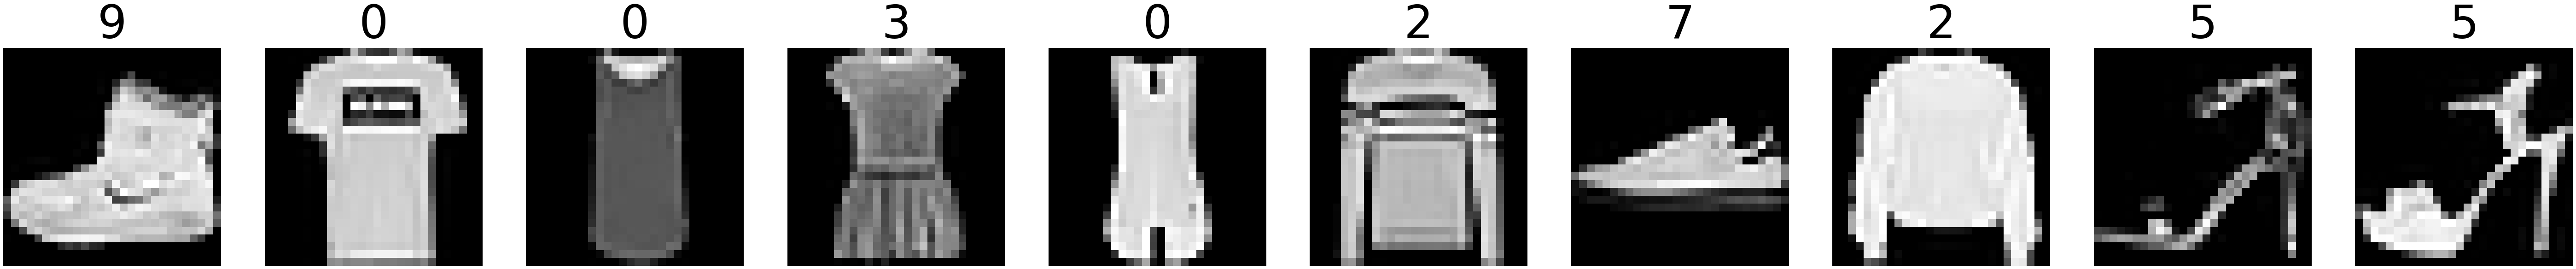

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(100, 10))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_input[i], cmap='gray') # 훈련데이터 앞의 열개만 plot
    plt.axis('off')
    plt.title('{}'.format(train_target[i]), size=100) # 타깃데이터 앞의 열개만 title
plt.show()

패션 MNIST 타깃은 0~9까지의 숫자 레이블로 구성된다

In [5]:
import numpy as np
np.unique(train_target, return_counts=True) # return_counts : 각 고유값 개수도 같이 확인

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

### 1. 로지스틱 회귀로 패션 아이템 분류
- 로지스틱회귀에 사용되는 경사하강법 클래스 : SGDClasifier(확률적경사하강법)
- SGDClassifier는 2차원 입력을 다루지 못하므로 각 샘플을 1차원 배열로 만든다

In [6]:
train_scaled = train_input / 255.0 # 각 샘플의 픽셀이 0~1의 값을 갖도록
train_scaled = train_scaled.reshape(-1, 28*28) # (60000개의 샘플, 각 샘플이 1열로 늘어섬)

In [7]:
train_scaled.shape # 784개의 픽셀로 이루어진 60,000개의 샘플

(60000, 784)

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss='log', max_iter=5, random_state=42) # 분류모델 생성
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1) # cross_validate() : k-폴드 교차 검증(default:5)
np.mean(scores['test_score']) # k-폴드 교차 검증 결과의 평균 값

0.8195666666666668

### 2. 인공신경망 활용하여 패션 아이템 분류

In [9]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [10]:
train_scaled.shape, train_target.shape

((48000, 784), (48000,))

### 밀집층(dense layer)을 만들자
Dense 클래스 사용

In [11]:
dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,))

- 뉴런 : 10개(z값 10개 나옴)
- 활성화 함수 : softmax, 10개의 분류이기 때문(이진분류인 경우 sigmoid)
- 입력의 크기 : 784

### 신경망 모델을 만들자
1. Sequential 클래스 사용 하여 모델 생성( + 밀집층 객체 전달)
2. 생성된 모델 객체의 compile 메서드 수행( + 손실함수의 종류 지정)

In [12]:
model = keras.Sequential(dense) # 밀집층 객체 전달

In [13]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

- compile 메서드의 매개변수
    1. 손실함수의 종류 지정
    - 이진분류 : loss = 'binary_crossentropy'
    - 다중분류 : loss = 'categorical_crossentropy'
    - 정수로된 타깃값을 그대로 사용해 크로스 엔트로피 손실을 계산하는 것 : 'sparse_categorical_crossentropy'
    - 원-핫 인코딩으로 준비된 타깃값으로 크로스 엔트로피 손실을 계산하는 것 : 'categorical_crossentropy'
    2. metrics 매개변수 : 에포크 마다 정확도를 함께 출력하도록 함

### 모델 훈련(fit)
- 로지스틱손실함수를 사용한 SGDClassifier 모델의 교차 검증 점수보다 정확도 높음

In [14]:
model.fit(train_scaled, train_target, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6086 - accuracy: 0.7945
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4784 - accuracy: 0.8411
Epoch 3/5
1500/1500 [==============================] - 2s 2ms/step - loss: 0.4569 - accuracy: 0.8487
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4429 - accuracy: 0.8524
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4359 - accuracy: 0.8561


### 검증세트의 성능 확인(evaluate)
- 검증세트의 정확도는 훈련세트의 정확도 보다 조금 낮은 것이 일반적

In [15]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.4478 - accuracy: 0.8528


[0.4478260576725006, 0.8528333306312561]

# 심층 신경망
- 입력층과 출력층 사이에 은닉층을 추가
- (분류를 위한 신경망)출력층에 적용하는 활성화 함수 : 이진분류 → 시그모이드, 다중분류 → 소프트맥스
- (분류를 위한 신경망)은닉층에 적용하는 활성화 함수 : 시그모이드, 렐루 함수

- 회귀를 위한 신경망의 출력층에는 활성화 함수를 적용하지 않는다

### 은닉층에 활성화 함수(시그모이드/렐루 등)를 적용하는 이유
계산된 z값을 비선형적으로 비틀어서 나름의 역할을 하도록 만들어줌

### 심층 신경망 만들기

In [16]:
dense1 = keras.layers.Dense(100, activation='sigmoid', input_shape=(784, )) # 은닉층 : 뉴런개수는 기준이 없다(경험적)
dense2 = keras.layers.Dense(10, activation='softmax') # 출력층 : 10개의 클래스를 분류하므로 10개의 뉴런과 소프트맥스 함수 사용

In [17]:
model = keras.Sequential([dense1, dense2]) # Sequential 클래스의 객체를 만들때 밀집층[은닉층, 출력층] 전달

In [18]:
model.summary() # 유용한 정보를 주는 summary 메서드

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


출력 크기 (None, 100) : fit 메서드로 아직 훈련을 하지 않았음

Param : 각 밀집층 마다의 파라미터 개수가 표시됨

### 층을 추가하는 다른 방법
1. Dense 클래스 객체인 dense1, dense2를 만들어 Sequential 클래스에 전달하는 방법
2. Sequential 클래스의 생성자 안에서 바로 Dense클래스의 객체를 만드는 방법 : 많이 쓰임
3. Sequential 클래스로 이미 만들어진 모델에 층을 추가하는 동적인 방법 : add() 메서드

In [19]:
model = keras.Sequential([
                          keras.layers.Dense(100, activation='sigmoid', input_shape=(784, ),
                                            name='hidden'),
                          keras.layers.Dense(10, activation='softmax', name='output')
                        ], name='패션 MNIST 모델') # 각 Dense층의 이름은 영문만 가능, model 이름은 한글도 가능 

In [20]:
model.summary()

Model: "패션 MNIST 모델"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 100)               78500     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [21]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(784, )))
model.add(keras.layers.Dense(10, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [23]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5571 - accuracy: 0.8110
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4059 - accuracy: 0.8522
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3704 - accuracy: 0.8662
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3496 - accuracy: 0.8724
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3314 - accuracy: 0.8789


### Flatten 클래스
- 넘파이 배열을 1차원으로 펼치는 reshape() 메서드
- 케라스에서 제공하는 Flatten() 클래스 : 층처럼 입력층과 은닉층 사이에 추가


In [24]:
model = keras.Sequential() # 모델을 먼저 생성
model.add(keras.layers.Flatten(input_shape=(28, 28))) # 입력값의 차원을 짐작할 수 있는것이 장점
model.add(keras.layers.Dense(100, activation='relu', input_shape=(784, ))) # 활성화 함수로 렐루(relu) 적용
model.add(keras.layers.Dense(10, activation='softmax'))

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               78500     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


입력 데이터에 대한 전처리 과정을 가능한 모델에 포함시키는 것이 케라스 API의 철학
 - 2차원(28, 28) → 1차원(784, )

In [28]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state = 42)

In [29]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 6s 3ms/step - loss: 0.5380 - accuracy: 0.8102
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3961 - accuracy: 0.8585
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3589 - accuracy: 0.8716
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3344 - accuracy: 0.8789
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3200 - accuracy: 0.8858


시그모이드 함수를 적용했을때 보다 정확도 높음

In [30]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3821 - accuracy: 0.8702


[0.38214319944381714, 0.8701666593551636]

은닉층을 추가하지 않은 경우보다 성능향상

### 옵티마이저
- compile() 메서드의 기본 경사 하강법 알고리즘 : RMSprop
- 설정할 수 있는 다양한 경사 옵티마이저 알고리즘이 있음 : 기본경사하강법(SGD), 적응적학습률(RMSprop, Adam)

 적응적학습률 : 모델이 최적점에 가까이 갈수록 학습률을 낮춰서 안정적으로 최적점에 수렴하도록  

In [ ]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentrophy', metrics='accuracy')

In [ ]:
sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd, loss='sparse_categorical_crossentrophy', metrics='accuracy')

위의 두 코드는 정확히 동일하다 

원래 sgd=keras.optimizers.SGD() 처럼 SGD 클래스 객체를 생성한 후 사용해야 하나,

번거로움을 피하고자 'sgd'라고 지정하면 자동으로 SGD 클래스 객체를 만들어줌

경사하강법 옵티마이저인 SGD의 파라미터
1. learning_rate : 만약 설정한 옵티마이저(예 : SGD)의 학습률 기본값(0.01)을 바꾸고자 한다면
2. momentum : 기본값(0), 이전의 그레디언트를 가속도처럼 사용(>0), 보통 0.9
3. nestrov : 기본값(False), 모멘텀 최적화를 2번 반복(True) 

In [ ]:
sgd = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)

# 손실곡선

### Histroy 객체이용
- fit() 메서드로 모델을 훈련하면 마지막에 출력되는 메시지 : <keras.callbacks.History at 0x7f4e8422de90>
- fit() 메서드는 Histroy 클래스 객체를 반환 : 훈련과정에서 계산한 지표(손실, 정확도)가 저장되 있음

In [31]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state = 42)

모델을 만드는 함수를 정의

In [36]:
def model_fn(a_layer=None):
    model = keras.Sequential() # 모델 생성
    model.add(keras.layers.Flatten(input_shape=(28, 28))) # Flatten층 추가 : 입력값을 2차원 → 1차원
    model.add(keras.layers.Dense(100, activation='relu')) # 밀집층 추가(활성화 함수 : relu)
    if a_layer: # 함수에 전달되는 파라미터가 있으면
        model.add(a_layer) # 전달되는 파라미터로 밀집층 추가
    model.add(keras.layers.Dense(10, activation='softmax')) # 출력층 추가(활성화 함수 : softmax)
    return model # 모델 반환

In [37]:
model_fn() # 함수의 return값으로 model이 global되어 사용할 수 있음
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               78500     
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0) # fit메서드로 생성되는 history "클래스 객체"를 변수에 담는다

verbose 매개변수
 - 기본값(1), 에포크 마다 진행막대와 손실등의 지표 출력
 - 2 : 진행 막대 제외 출력
 - 0 : 훈련 과정을 보여주지 않음

In [42]:
history.history.keys() # histroy 클래스의 histroy 메서드로 담겨있는 딕셔너리의 키값 확인

dict_keys(['loss', 'accuracy'])

손실(loss), 정확도(accuracy)는 에포크 마다 계산한 값이 순서대로 나열된 리스트